# Almond Classification Model

# Imports

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import chi2_contingency


from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix


# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [53]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df, col):
  salary_skewness = df[col].skew()
  salary_kurtosis = df[col].kurtosis()

  plt.figure(figsize=(10, 6))
  sns.histplot(df[col], kde=True, color='blue')
  plt.title(f'Distribution of {col} with Skewness and Kurtosis')
  plt.xlabel(col)
  plt.ylabel('Frequency')

  plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
  plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

  plt.grid(True)
  plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def chi_value_tests(df, interested_columns, target):
  
  for col in interested_columns:
    print(f"Column Is: {col}")
    contingency_table = pd.crosstab(df[target], df[col])
    chi2, p_val, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Test:\nChi2 Statistic: {chi2}, P-value: {p_val}")

def create_sklearn_pipeline( model, kbest=None):
  
  steps = [
    ("scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline( pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='macro')
    precision_metric = precision_score(y, predictions, average='macro')
    f1_metric = f1_score(y, predictions, average='macro')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models( model_names, models, X, y, scoring_metric, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sklearn_pipeline(model, kbest)
    else:
        pipeline = create_sklearn_pipeline(model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.plot(models_index, marker='o', label='recall-Score')
  plt.plot(models_index, marker='o', label='precision-Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()

  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False)
  return performance_df

def test_kbest_columns( X, y, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sklearn_pipeline(model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)


def optimization_search(model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker, best_models = [], []

  for model_name, model in zip(model_names, models):
    model_pipeline = create_sklearn_pipeline( model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=10, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    best_models.append(best_model)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return (pd.DataFrame(metric_tracker).sort_values(by="Test-Acc", ascending=False), best_models)

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/Almond.csv")
df

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


In [4]:
df.drop("Unnamed: 0", axis=1, inplace=True)

# Check Class Imbalance

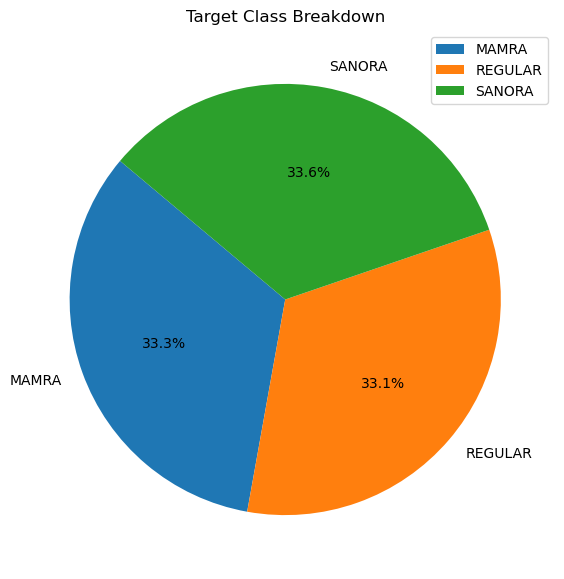

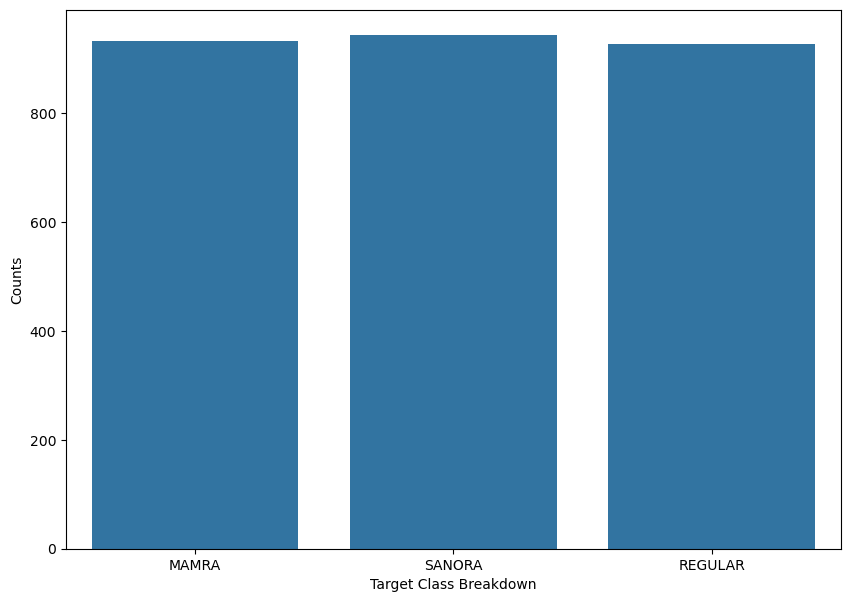

In [5]:
check_class_imbalance(df["Type"])

# Balanced Dataset

In [6]:
check_for_nulls_dupes(df)

The amount of Null Values: Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64
The amount of Duplicated Values 3


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.describe()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
count,1944.000000,1859.000000,1797.000000,2800.000000,2800.000000,1944.000000,2800.000000,2800.000000,1003.000000,1003.000000,2800.000000,2800.000000
mean,290.477086,171.037676,109.727607,26503.354107,743.573293,0.470611,0.955919,1.823211,1.752777,0.813038,0.724664,27686.578750
std,62.610007,29.896653,18.938723,13763.416459,230.367902,0.118604,0.039358,0.789515,0.206252,0.041261,0.047410,14215.481045
min,151.335266,88.050529,59.494278,6037.000000,311.563489,0.173748,0.718772,1.164469,1.400082,0.699897,0.454538,6355.000000
25%,245.916424,149.477875,97.267624,16214.000000,571.552339,0.385183,0.944733,1.357361,1.612441,0.784461,0.701889,17093.500000
50%,279.871277,170.168365,110.289268,23421.000000,707.144223,0.473275,0.970482,1.576375,1.705669,0.810108,0.733778,24581.000000
75%,330.273262,190.612556,121.393219,33448.000000,878.825462,0.577628,0.981490,1.963977,1.833105,0.838096,0.757594,34862.875000
max,515.352478,258.569794,181.845200,89282.000000,1864.947387,0.697293,0.992889,9.660057,2.731251,0.930563,0.845813,90642.500000


# We Will have to plug in all of this missing data with either the mean, median or a prediction model. We Will test numerous choices

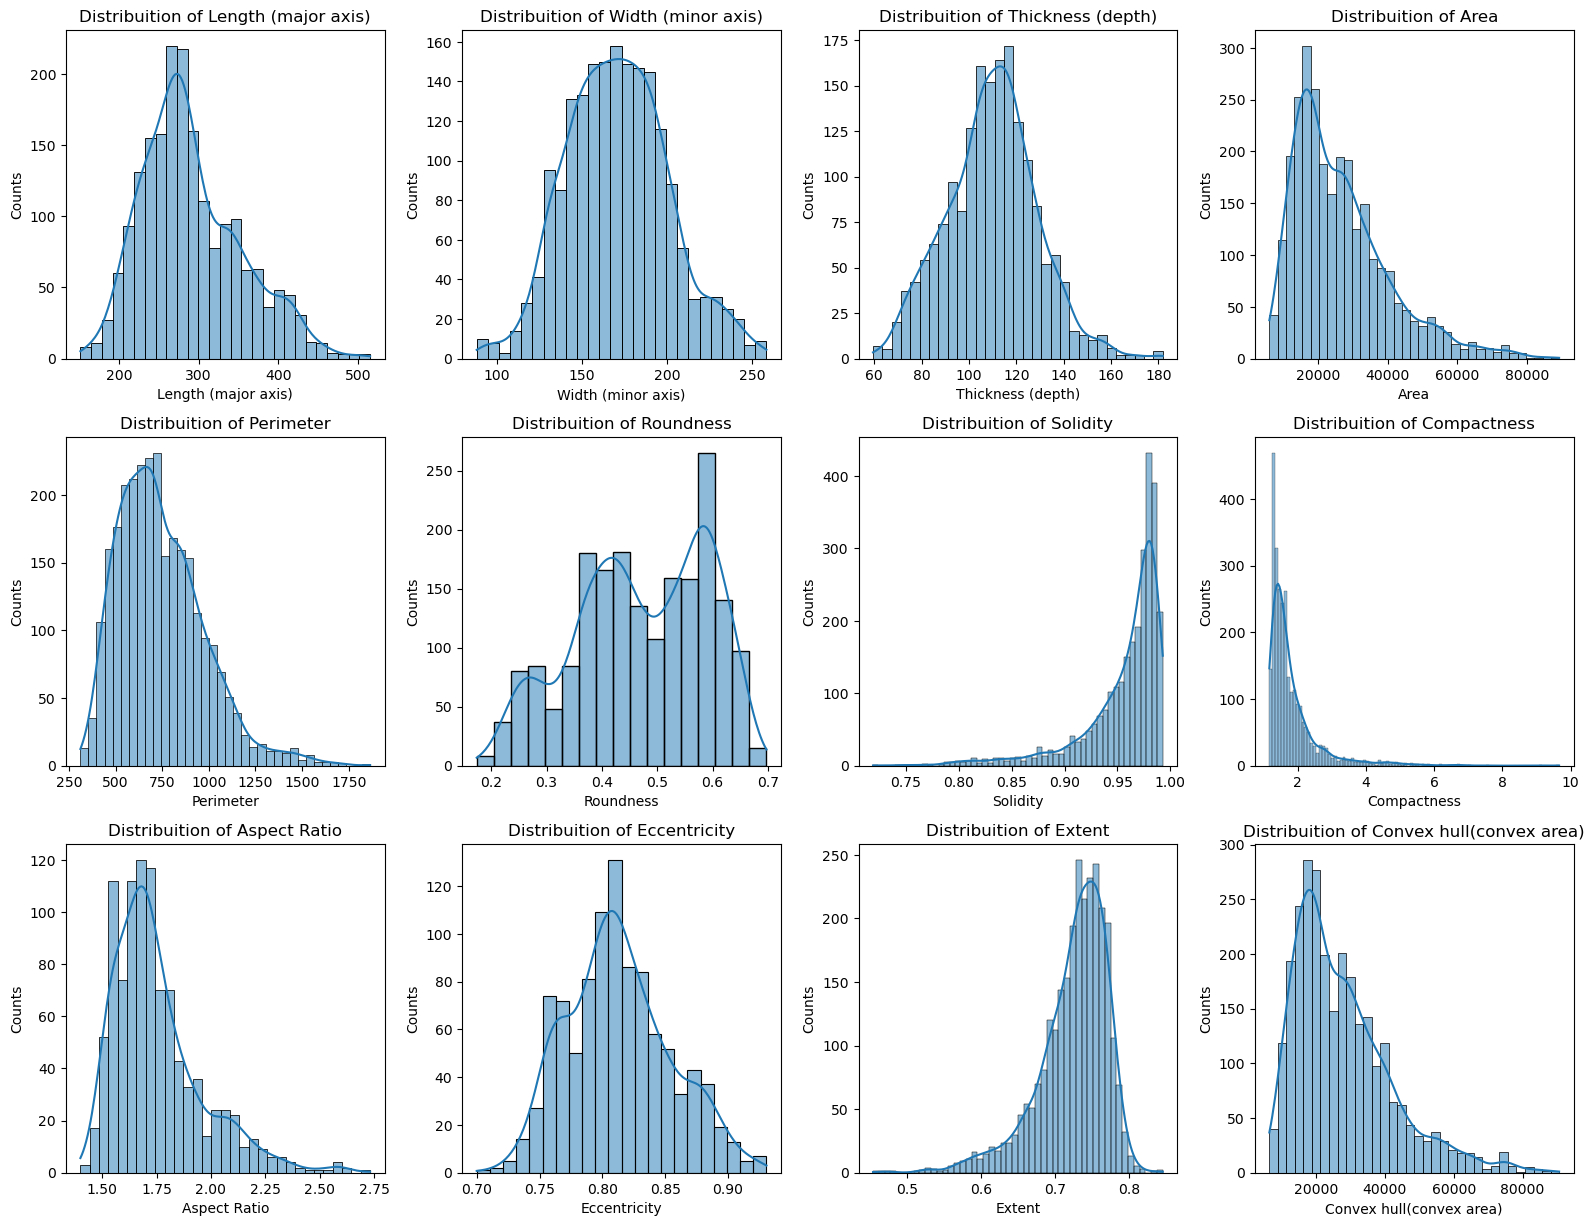

In [9]:
plot_distribution(df, "hist")

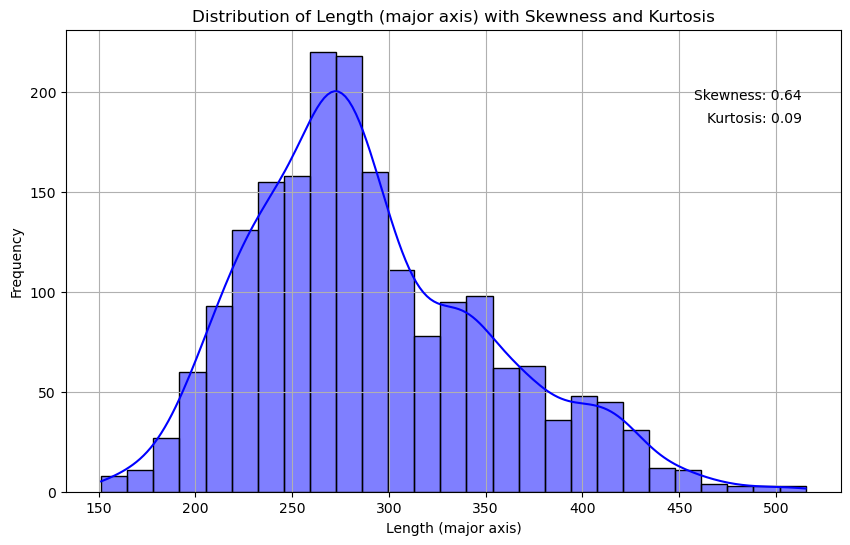

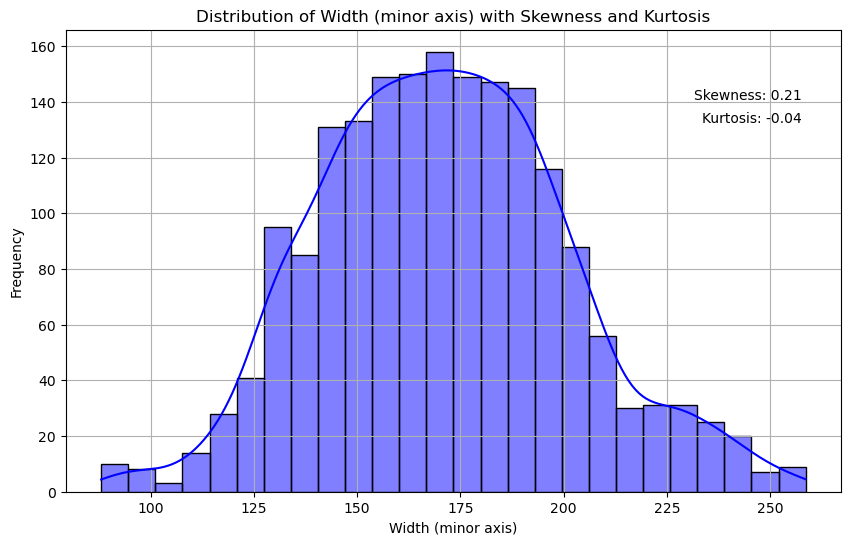

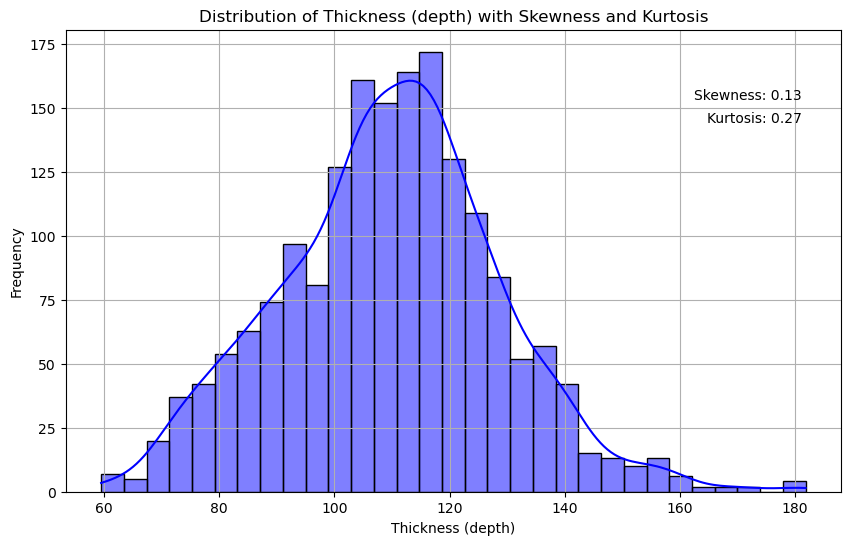

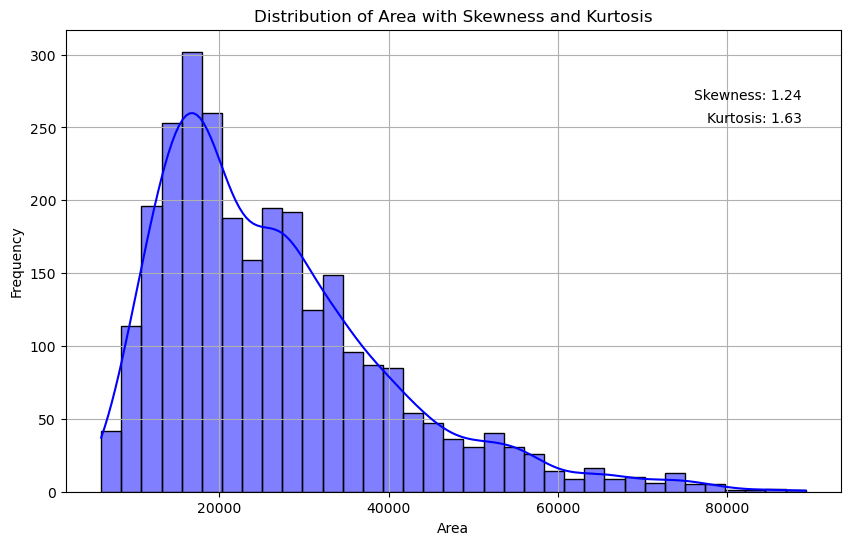

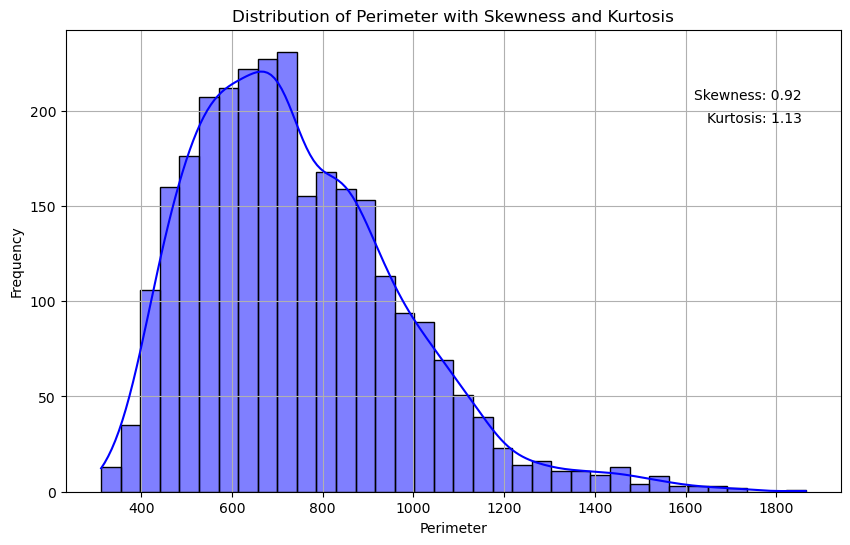

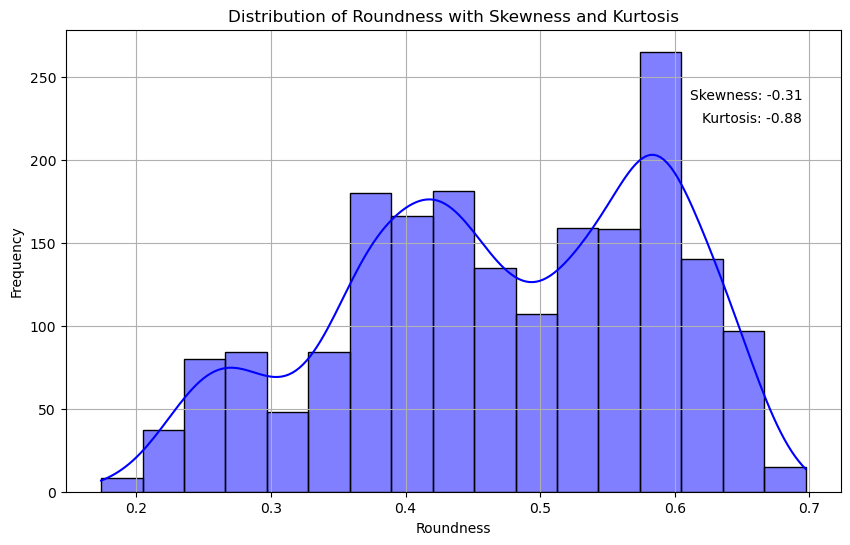

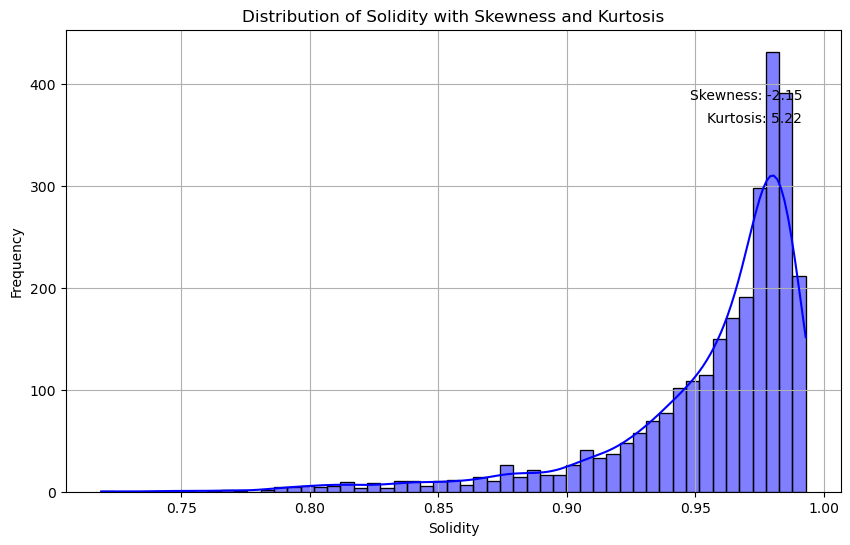

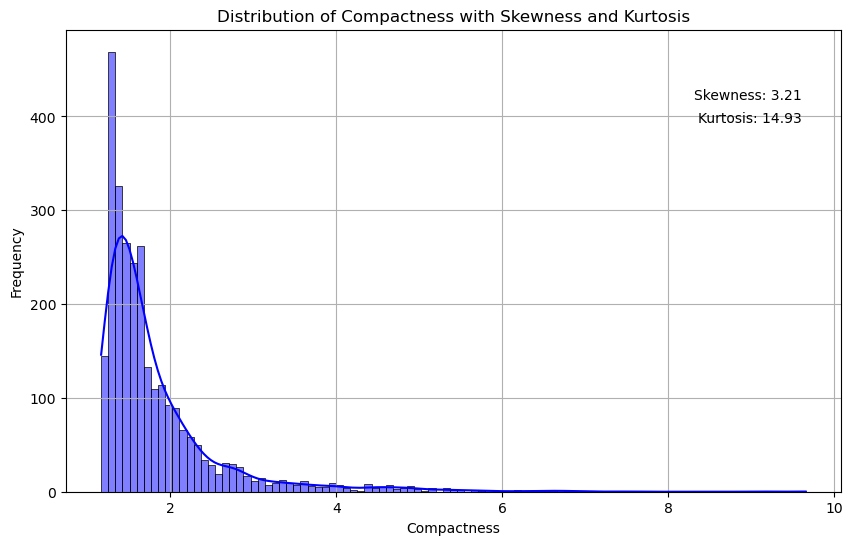

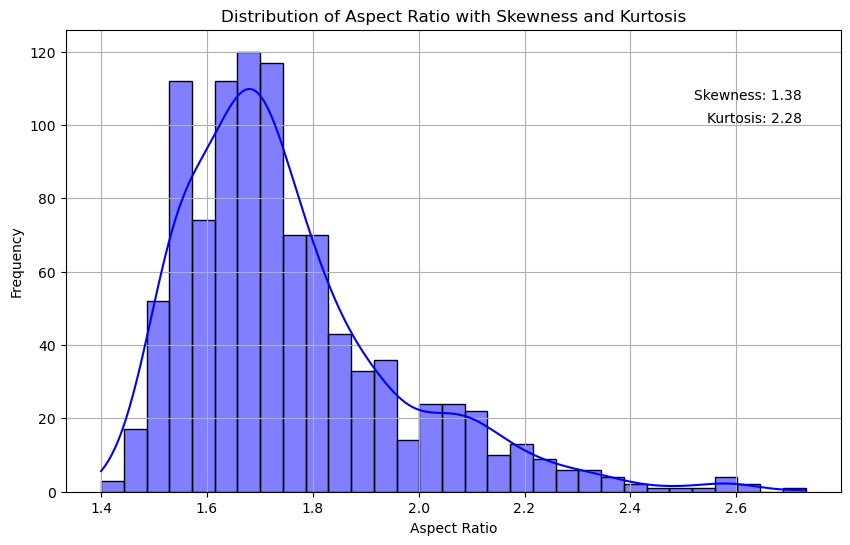

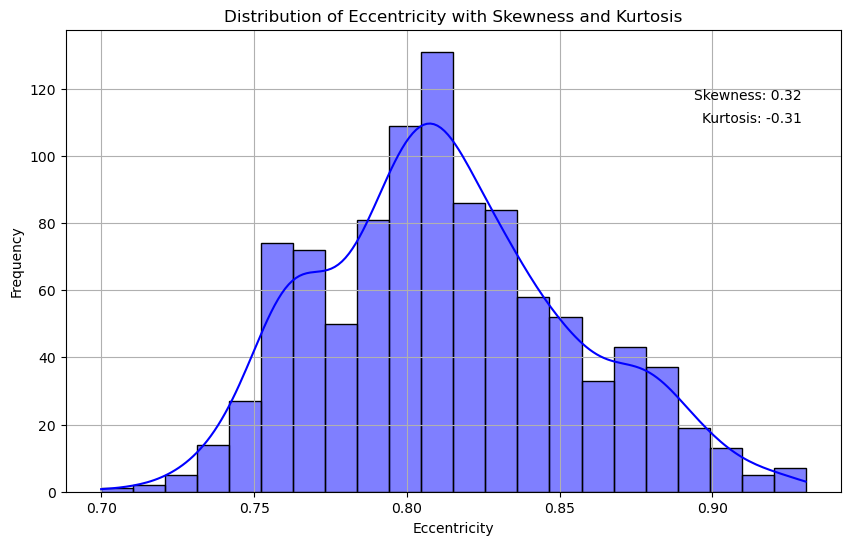

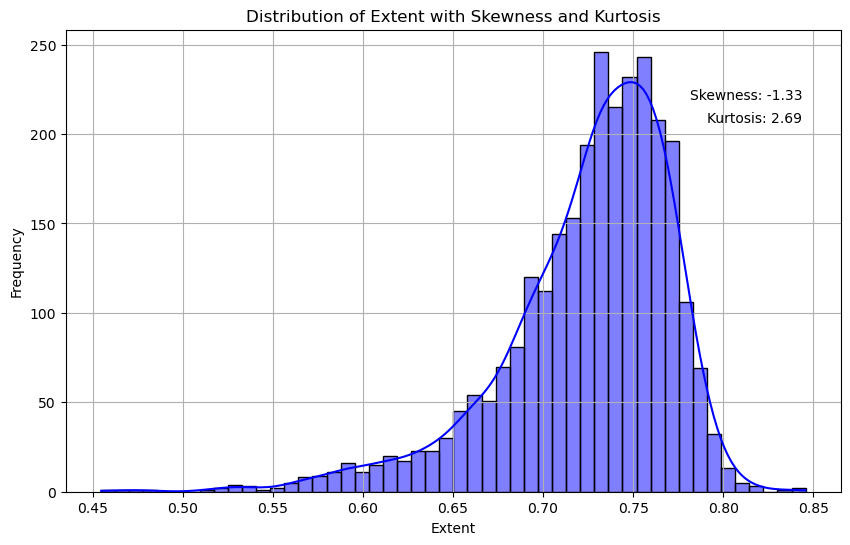

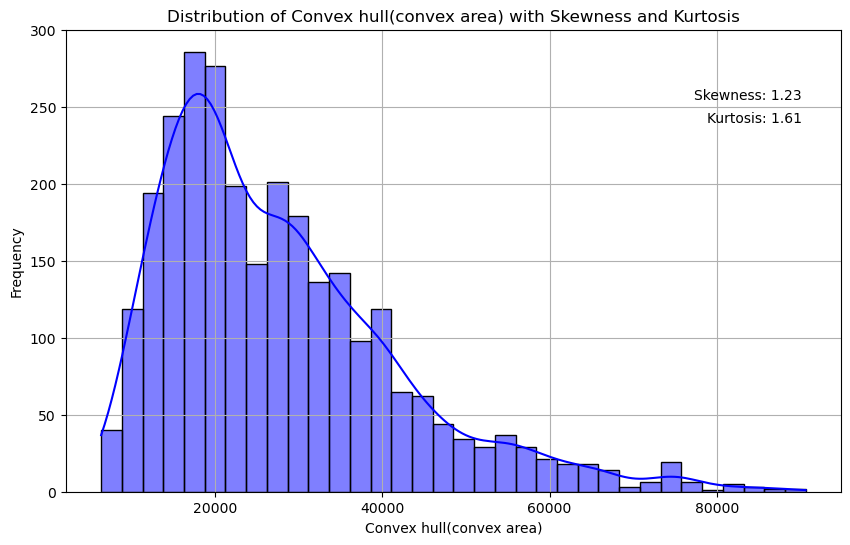

In [10]:
for col in df.columns:
  if col == "Type":
    continue
  dist_plot(df, col)

# If the skewness is between 0.5 and -0.5 then mean if it greater than 0.5 to -0.5 than median

In [11]:
# Length (major axis)          857 = median
# Width (minor axis)           942 = mean
# Thickness (depth)           1004 = mean
# Roundness                    857 = median
# Aspect Ratio                1799 = median
# Eccentricity                1799 = mean

In [12]:
mean_values = [
  "Width (minor axis)",
  "Thickness (depth)",
  'Eccentricity'
  ]

median_values = [
  "Length (major axis)",
  "Roundness",
  'Aspect Ratio'
]

# Processoed DF

In [13]:
process_df = df.copy()

for mean_col, median_col in zip(mean_values, median_values):
  process_df[mean_col] = process_df[mean_col].fillna(process_df[mean_col].mean())
  process_df[median_col] = process_df[median_col].fillna(process_df[median_col].median())


In [14]:
process_df.isna().sum()

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64

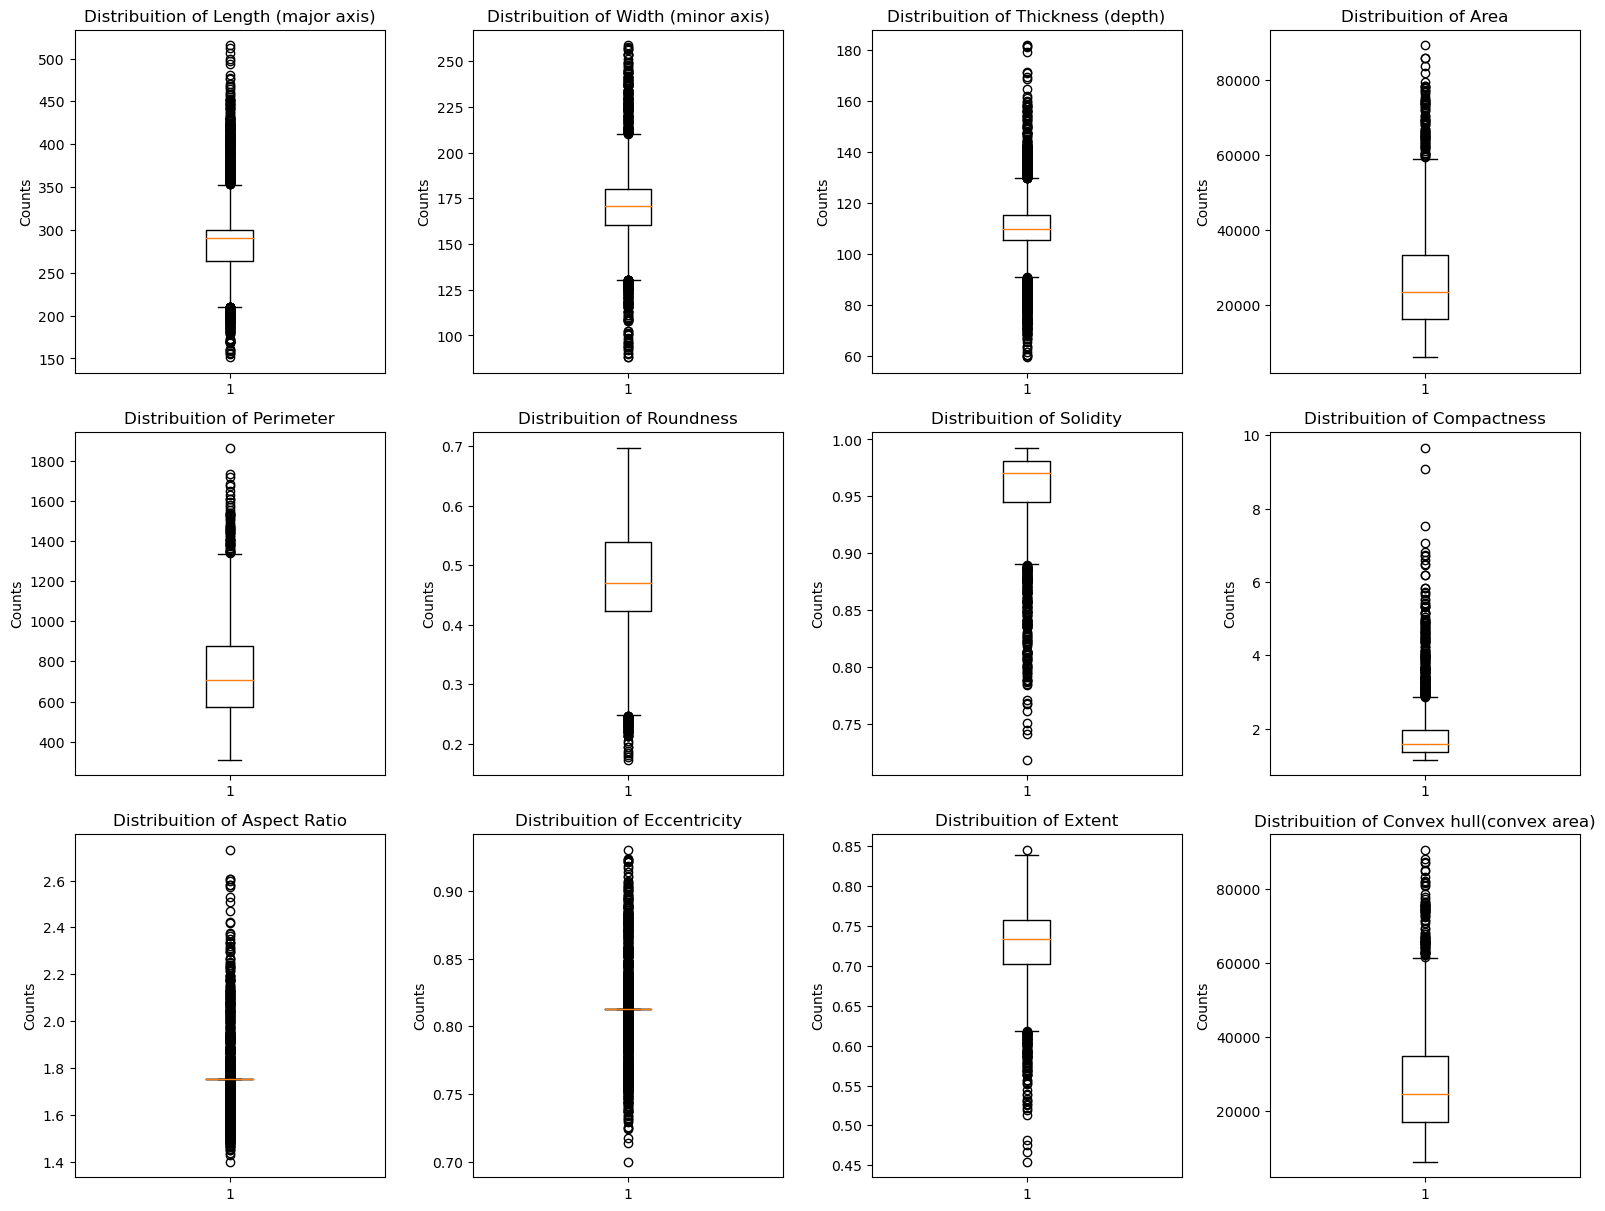

In [15]:
plot_distribution(process_df, 'box')

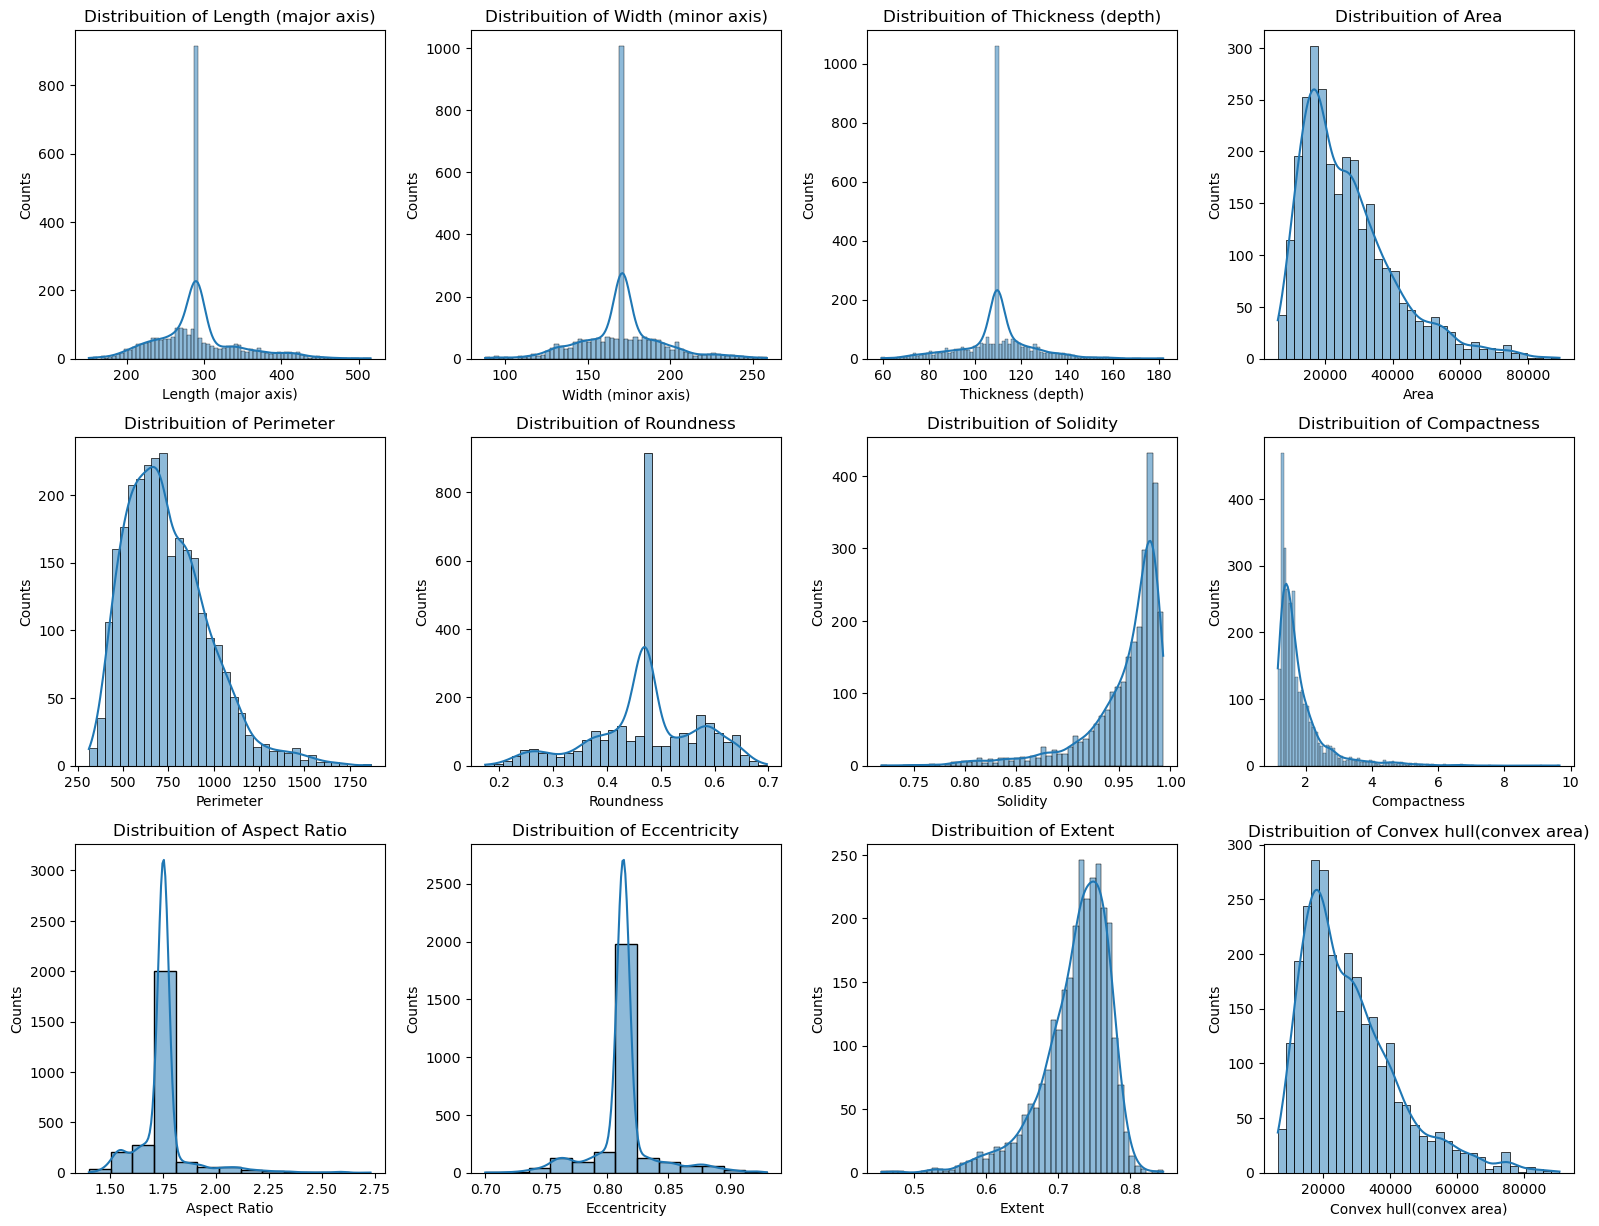

In [16]:
plot_distribution(process_df, 'hist')

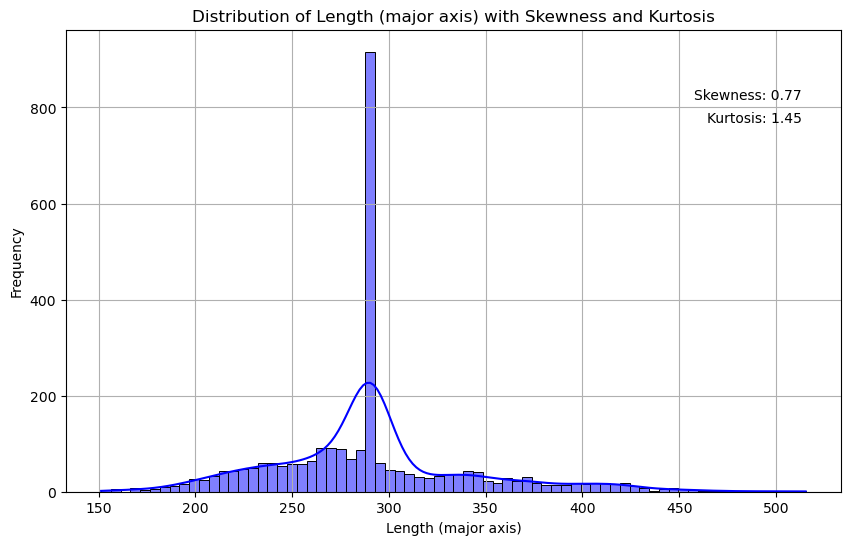

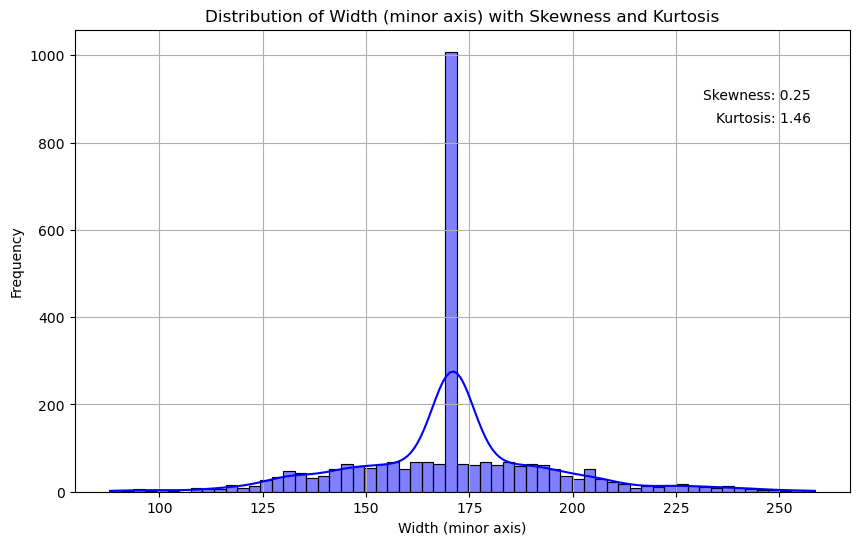

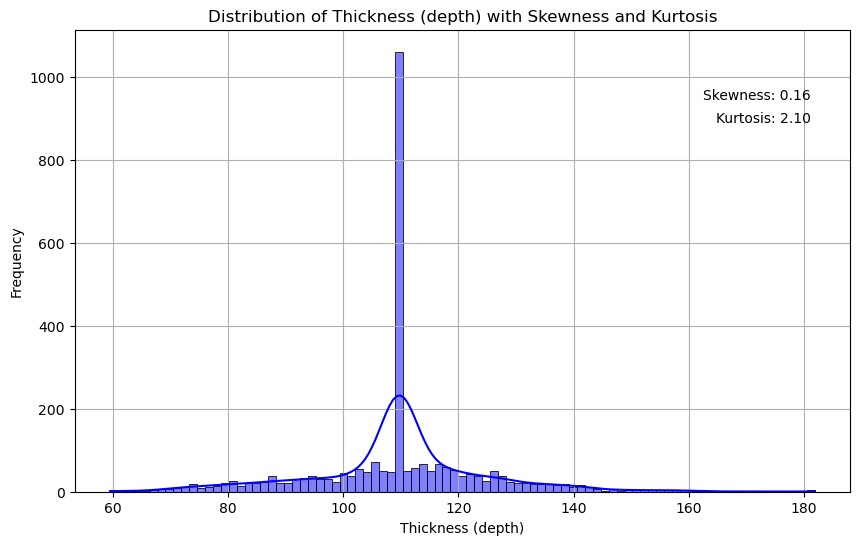

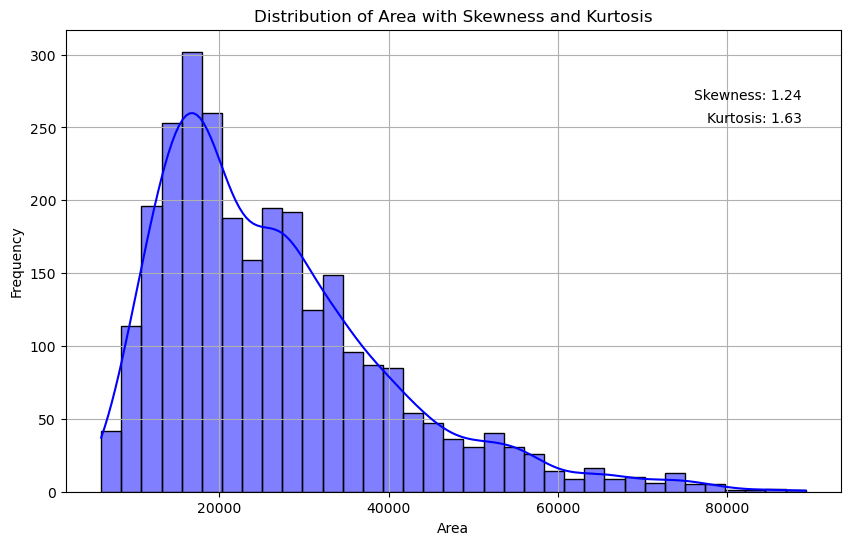

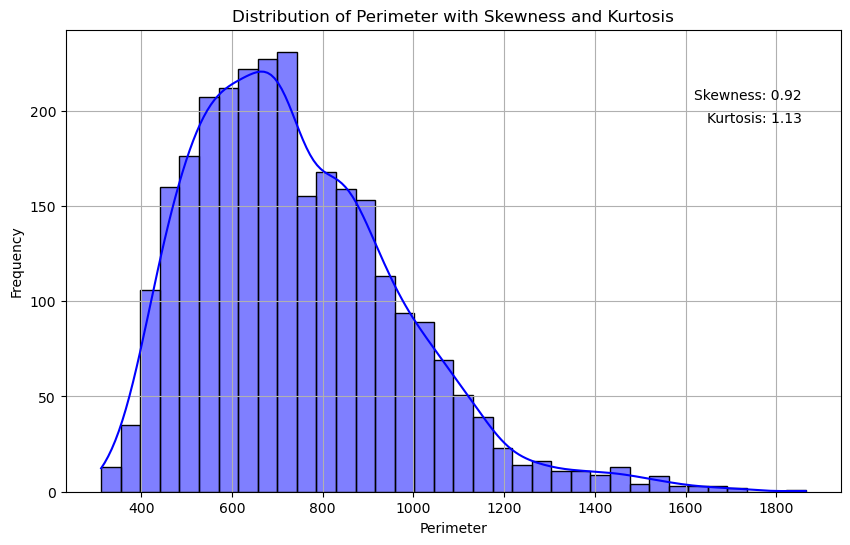

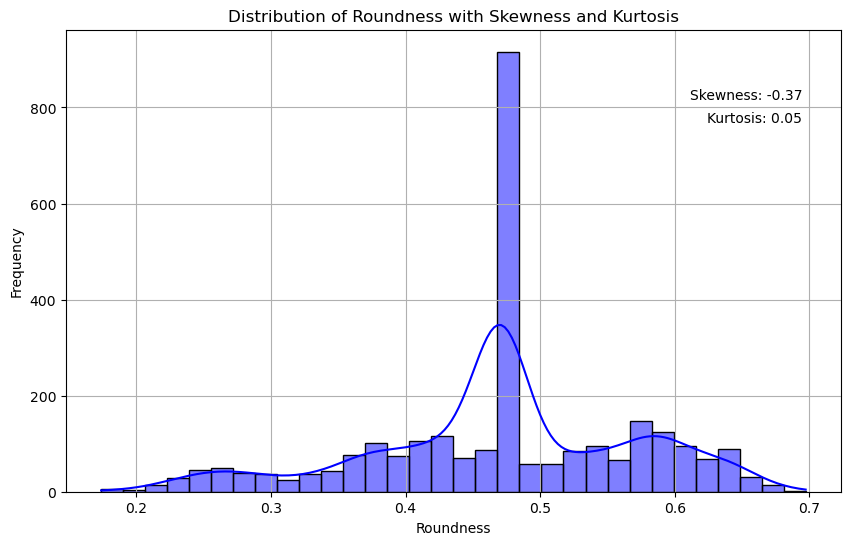

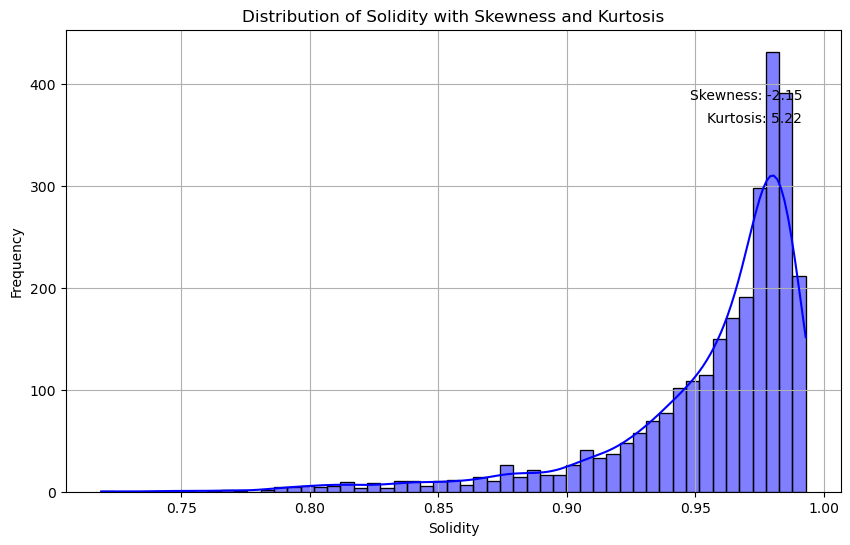

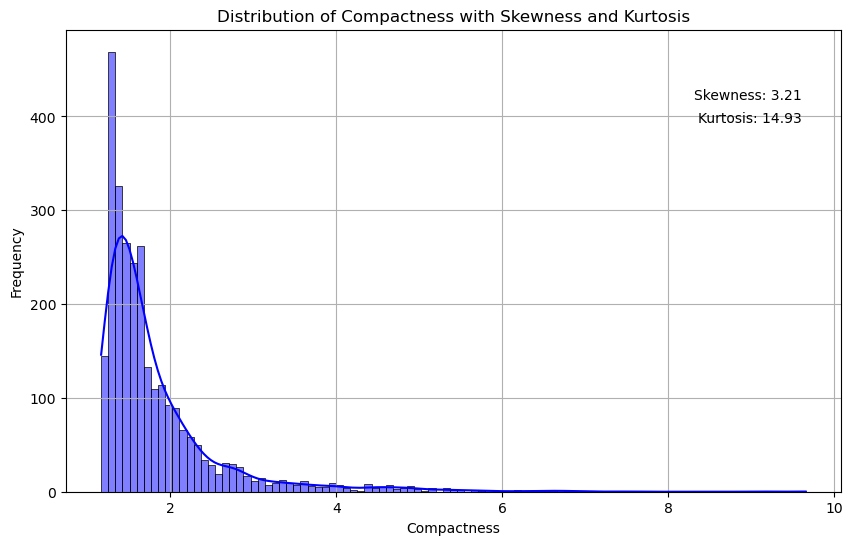

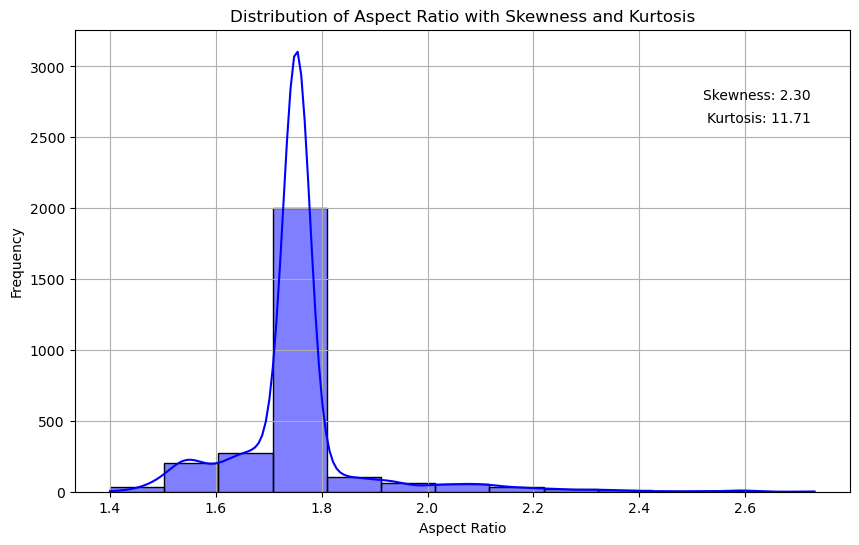

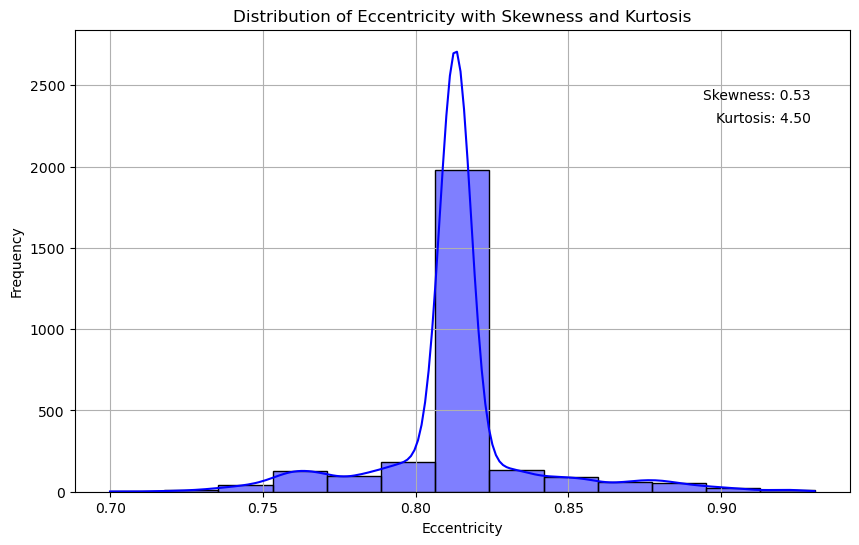

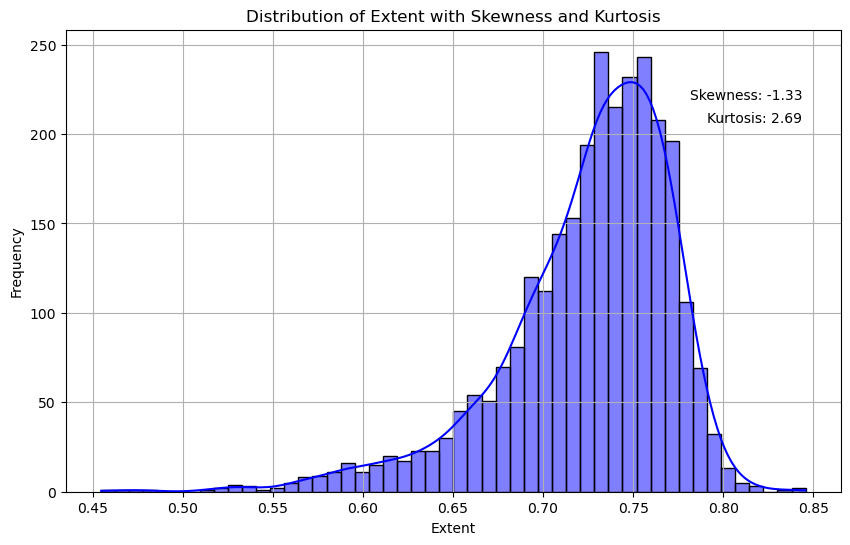

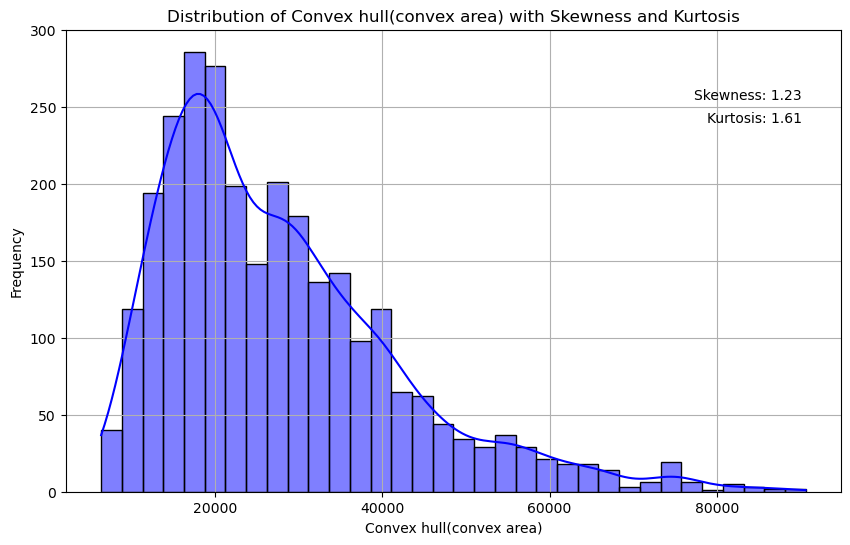

In [17]:
for col in df.columns:
  if col == "Type":
    continue
  dist_plot(process_df, col)

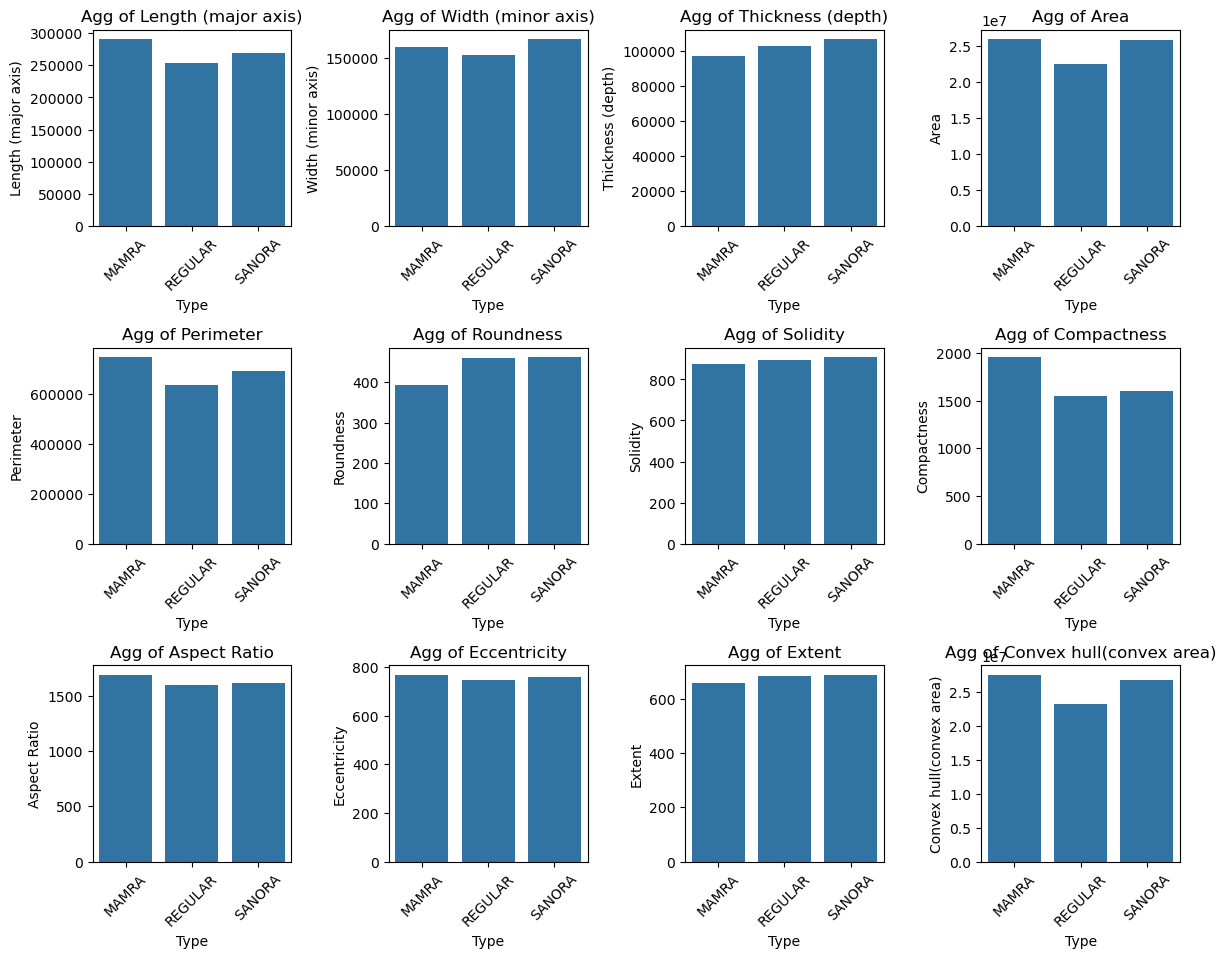

In [18]:
aggregate_dataset(process_df, process_df.columns, 'Type', "sum")

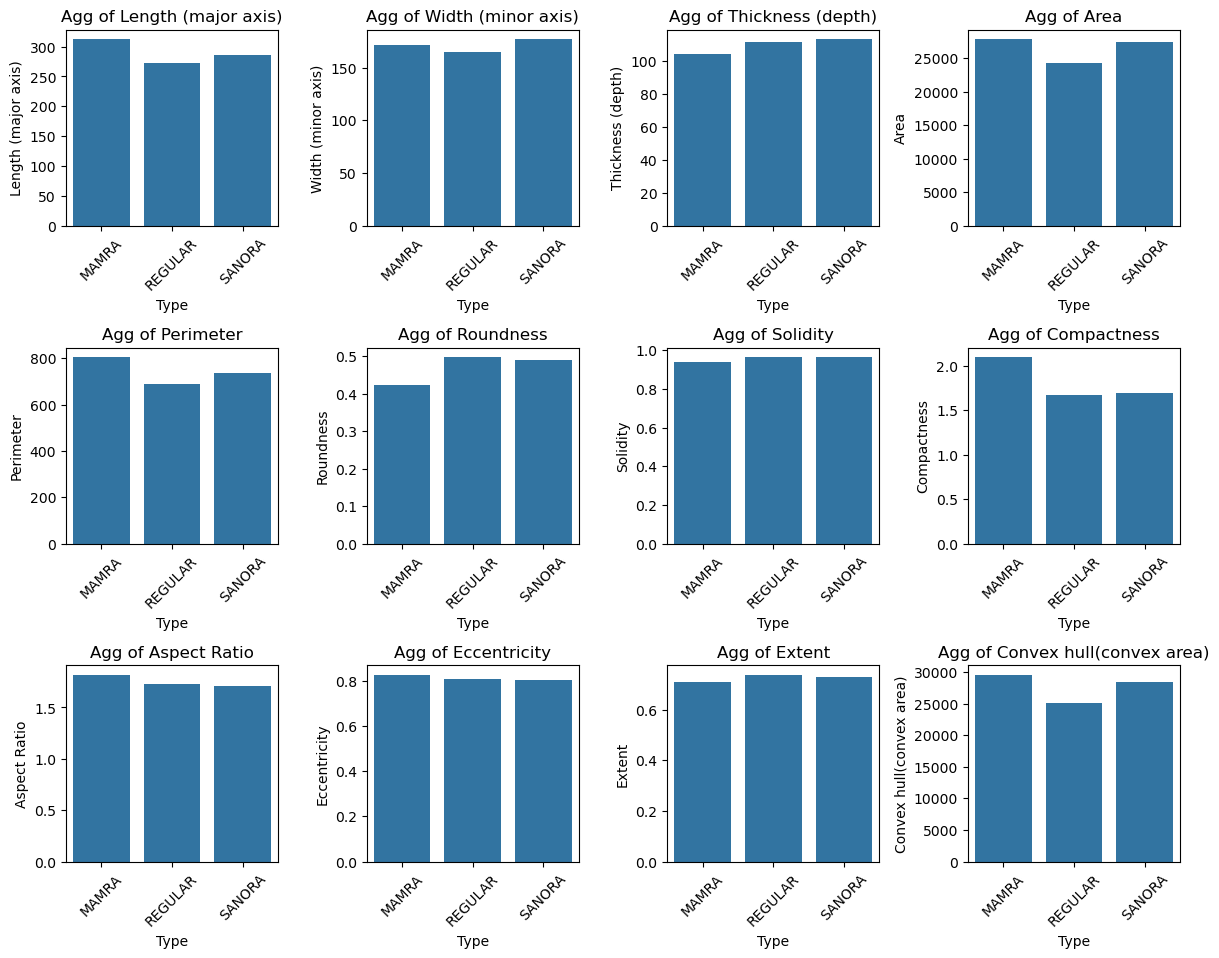

In [19]:
aggregate_dataset(process_df, process_df.columns, 'Type', "mean")

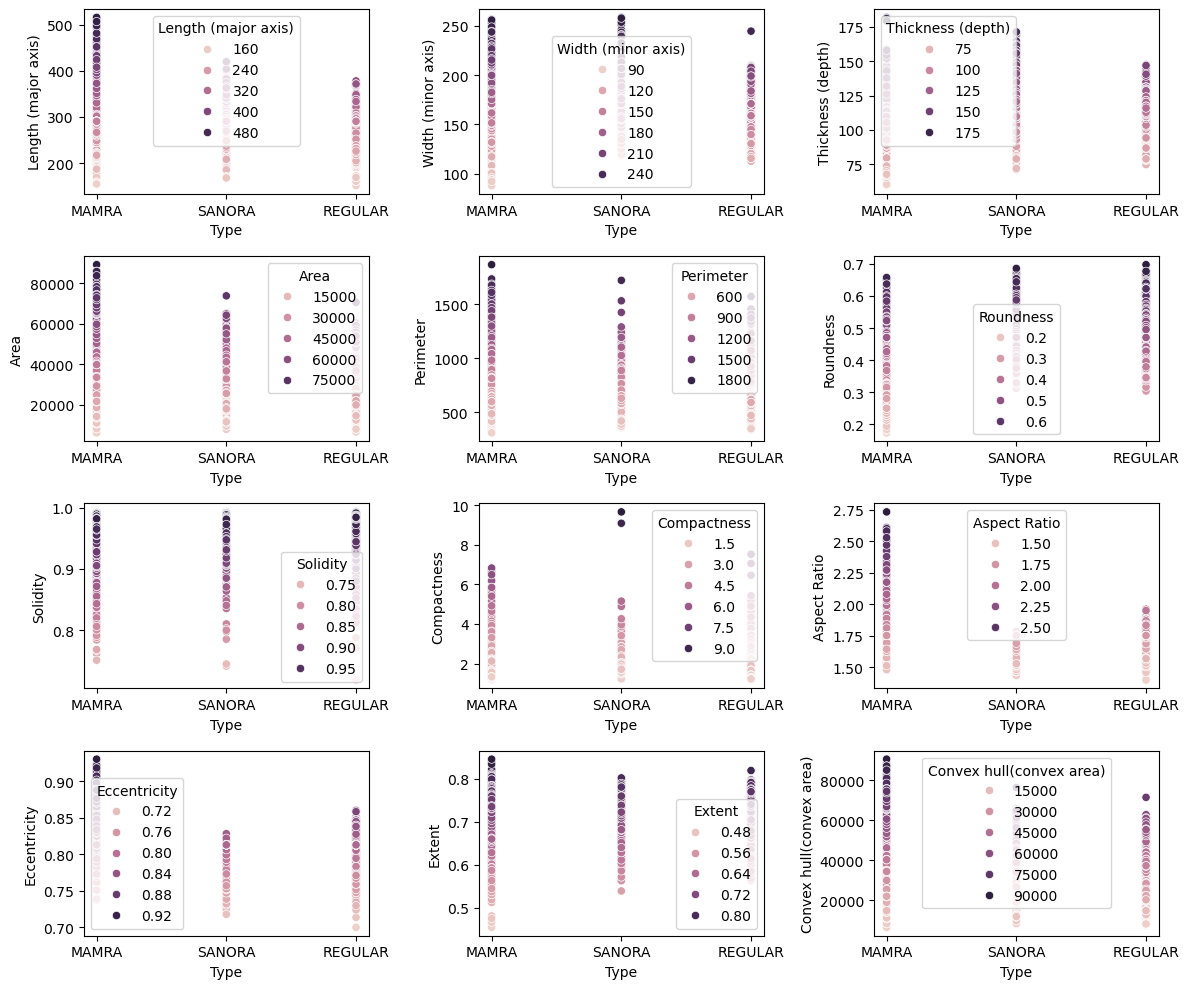

In [20]:
scatter_plot(process_df, process_df.columns, "Type")

# Chi Test

In [21]:
interested_columns = [col for col in process_df.columns if col != "Type"]

In [22]:
chi_value_tests(process_df, interested_columns, "Type")

Column Is: Length (major axis)
Chi-Square Test:
Chi2 Statistic: 3890.266134914012, P-value: 0.4867362650032415
Column Is: Width (minor axis)
Chi-Square Test:
Chi2 Statistic: 3718.3427190749876, P-value: 0.4953303470650851
Column Is: Thickness (depth)
Chi-Square Test:
Chi2 Statistic: 3596.3011911907643, P-value: 0.4860400223725692
Column Is: Area
Chi-Square Test:
Chi2 Statistic: 5513.002278995796, P-value: 0.4406610632303874
Column Is: Perimeter
Chi-Square Test:
Chi2 Statistic: 5594.006994816872, P-value: 0.45979760906449063
Column Is: Roundness
Chi-Square Test:
Chi2 Statistic: 3890.2661349140117, P-value: 0.4867362650032436
Column Is: Solidity
Chi-Square Test:
Chi2 Statistic: 5600.0, P-value: 0.48994781881339866
Column Is: Compactness
Chi-Square Test:
Chi2 Statistic: 5599.999999999999, P-value: 0.4899478188134021
Column Is: Aspect Ratio
Chi-Square Test:
Chi2 Statistic: 2008.1759567849379, P-value: 0.4821072804656712
Column Is: Eccentricity
Chi-Square Test:
Chi2 Statistic: 2008.17595678

# Separate X, y values

In [23]:
X = process_df.drop("Type", axis=1)
y = process_df["Type"]

In [24]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

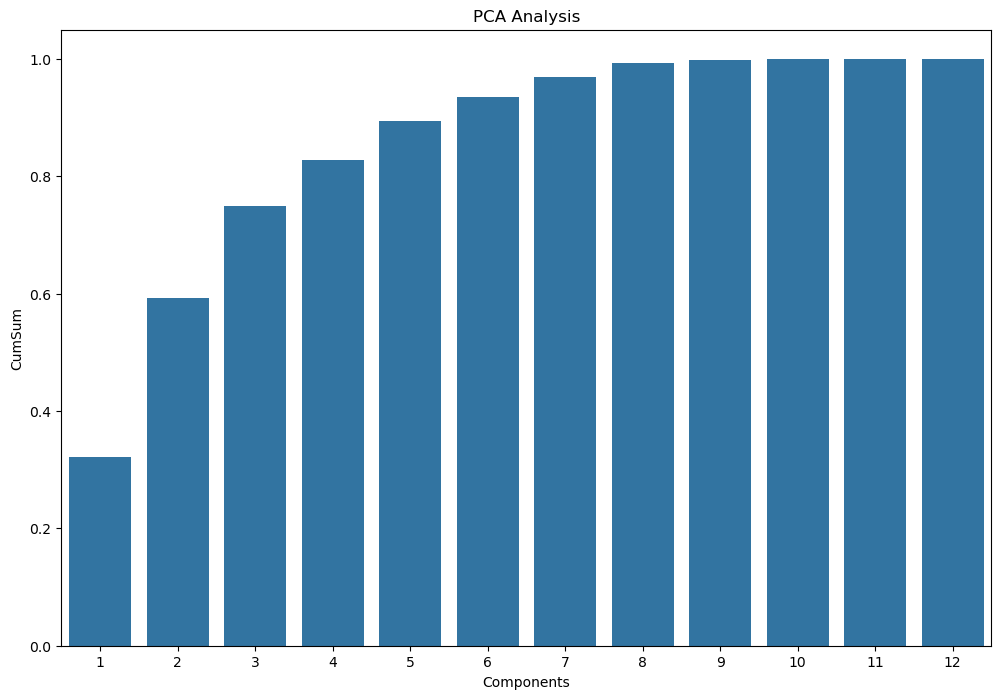

,Component,CumSum
0,1,0.320937
1,2,0.593334
2,3,0.749709
3,4,0.827604
4,5,0.894235
5,6,0.935121
6,7,0.969133
7,8,0.992814
8,9,0.998276
9,10,0.999774


In [25]:
pca_analysis(X)

# Create Metrics

In [26]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="macro")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='macro')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='macro')

# Create Baseline Model

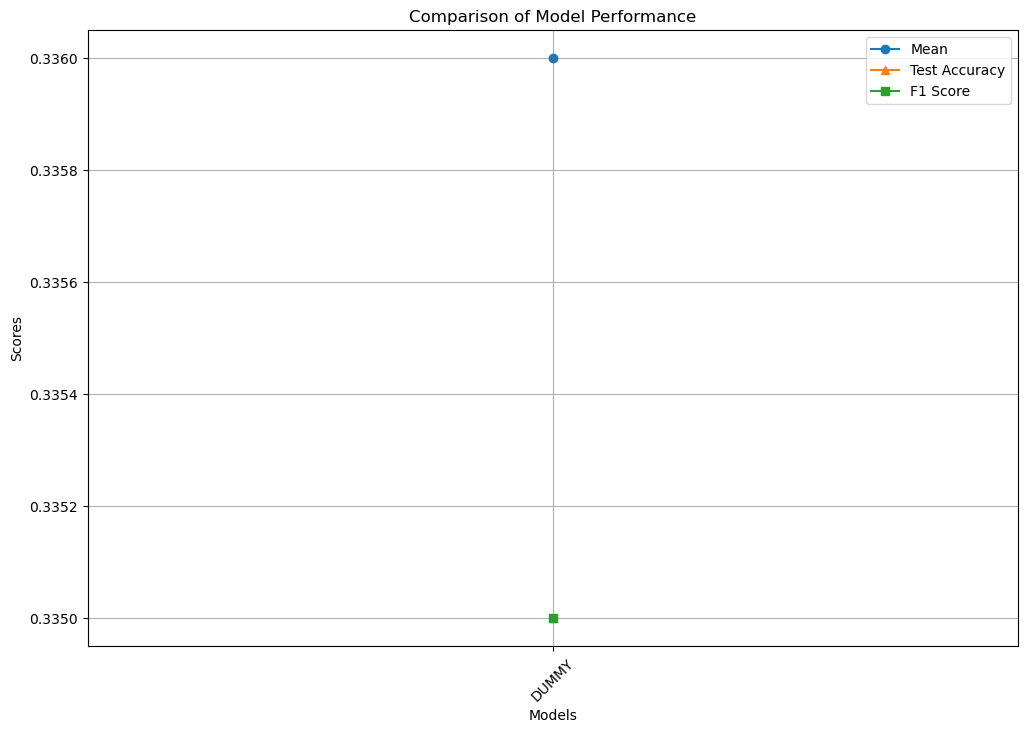

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,DUMMY,0.336,0.001,0.026,0.335,0.335,0.335,0.335


In [27]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
test_selected_models(model_name, models, X, y_encoded, acc_metric)

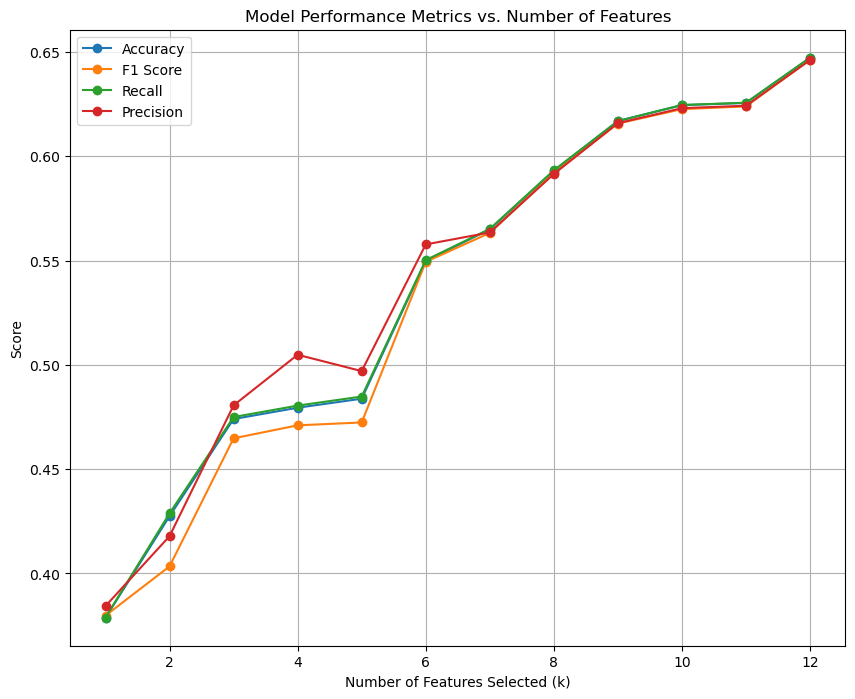

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.378788,0.379794,0.378865,0.384393
1,LR,2,0.427489,0.403404,0.428829,0.417877
2,LR,3,0.474026,0.464782,0.474979,0.480587
3,LR,4,0.479437,0.471008,0.480458,0.504834
4,LR,5,0.483766,0.472381,0.484811,0.496995
5,LR,6,0.549784,0.549373,0.550197,0.557718
6,LR,7,0.564935,0.563234,0.565161,0.563441
7,LR,8,0.593074,0.592061,0.593206,0.591471
8,LR,9,0.616883,0.615658,0.616814,0.615841
9,LR,10,0.624459,0.622574,0.624558,0.623025


In [28]:
model_name = ["LR"]
models = grab_selected_models(model_name)[0]
metric = mutual_info_classif
test_kbest_columns(X, y_encoded, models, model_name[0], metric)

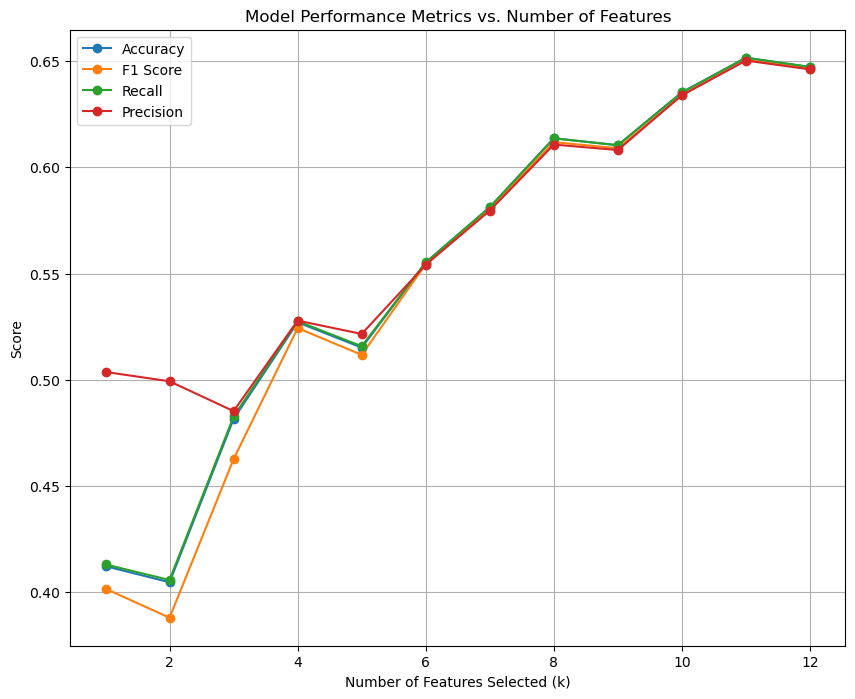

,Model,K,acc_metric,f1_metric,recall,precision
0,LR,1,0.412338,0.401725,0.413155,0.503720
1,LR,2,0.404762,0.388077,0.405824,0.499315
2,LR,3,0.481602,0.462697,0.482768,0.485278
3,LR,4,0.527056,0.524363,0.527564,0.527881
4,LR,5,0.515152,0.511755,0.515816,0.521584
5,LR,6,0.555195,0.554440,0.555259,0.554141
6,LR,7,0.581169,0.580267,0.581276,0.579644
7,LR,8,0.613636,0.611832,0.613661,0.610687
8,LR,9,0.610390,0.608955,0.610376,0.608118
9,LR,10,0.635281,0.633880,0.635238,0.633953


In [29]:
metric = f_classif
test_kbest_columns(X, y_encoded, models, model_name[0], metric)

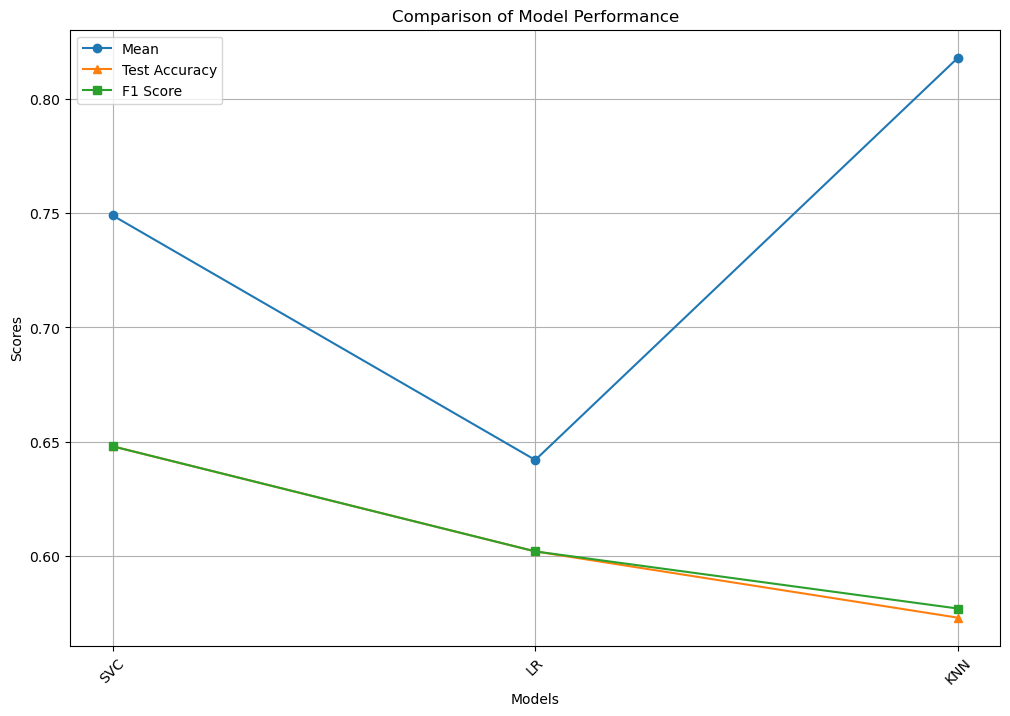

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
0,SVC,0.749,0.001,0.025,0.648,0.648,0.652,0.648
1,LR,0.642,0.001,0.028,0.602,0.602,0.602,0.602
2,KNN,0.818,0.001,0.024,0.573,0.573,0.581,0.577


In [30]:
kbest = SelectKBest(score_func=f_classif, k=12)
model_names = ["SVC", "LR", "KNN"]
models = grab_selected_models(model_names)
test_selected_models( model_names, models, X, y_encoded, acc_metric, kbest)

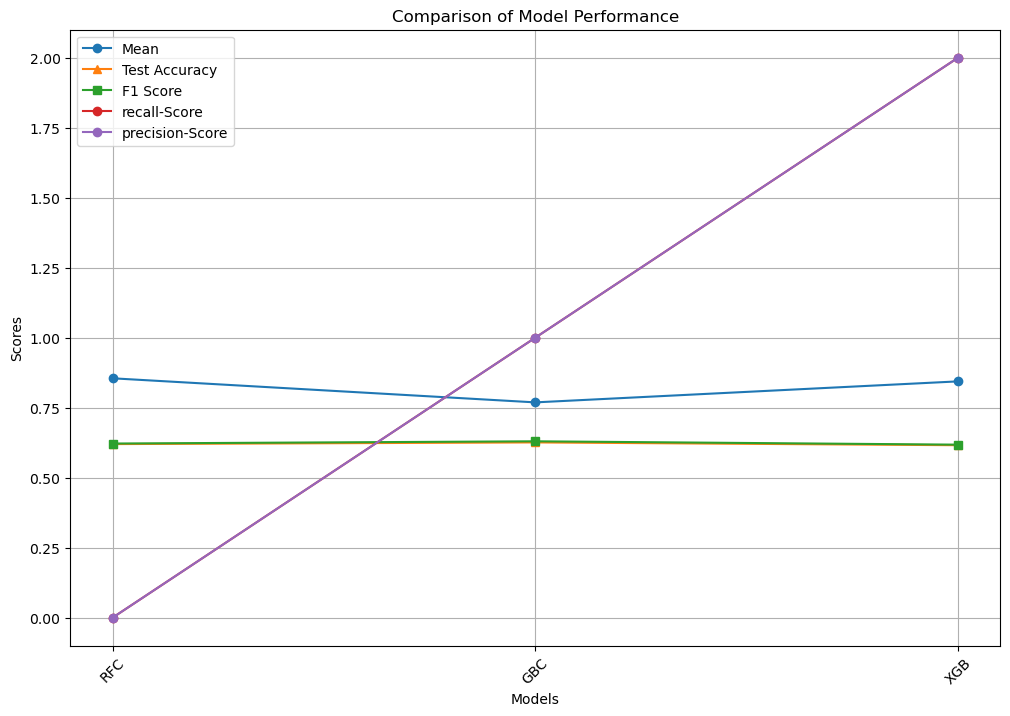

,Model,Mean,Var,STD,Test-Acc,recall-Score,precision-Score,F1-Score
1,GBC,0.769,0.001,0.026,0.626,0.626,0.637,0.630
0,RFC,0.855,0.001,0.022,0.620,0.620,0.625,0.622
2,XGB,0.844,0.001,0.026,0.616,0.616,0.621,0.618


In [34]:
model_names = ["RFC", "GBC", "XGB"]
models = grab_selected_models(model_names)
test_selected_models(model_names, models, X, y_encoded, acc_metric, kbest)

# Hyper Parameter Tuning

In [36]:
params = {
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 4],
        'model__min_samples_leaf': [1, 2]
    },
    'XGB': {
        'model__n_estimators': [100, 150, 200, 300],
        'model__learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1],
        'model__max_depth': [3, 5, 7, 9],
        'model__subsample': [0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.8, 1.0]
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'LR': {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear', 'saga']
    },
    'SVC': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
        'model__gamma': ['scale', 'auto'],
        'model__degree': [2, 3, 4]
    }
}

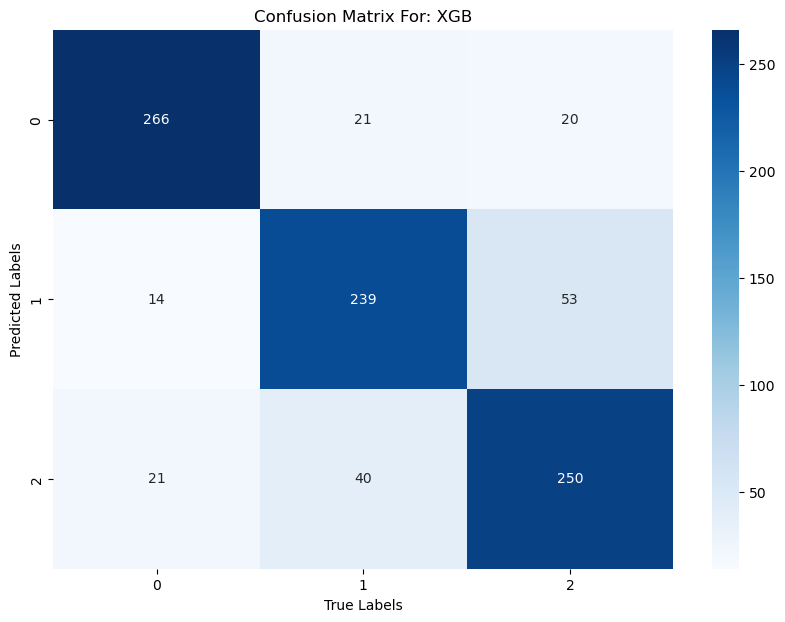

The Best Param: {'model__subsample': 0.8, 'model__n_estimators': 150, 'model__max_depth': 9, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


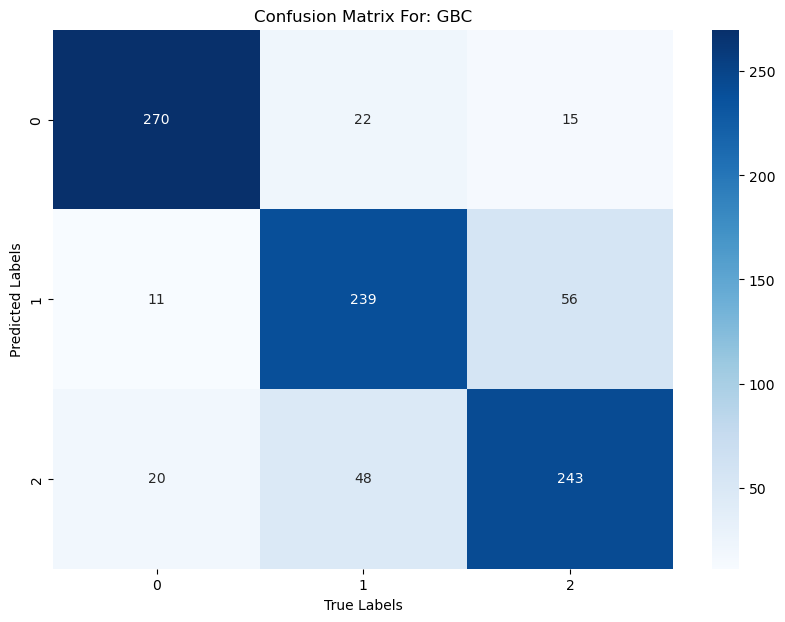

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': 5, 'model__learning_rate': 0.1}


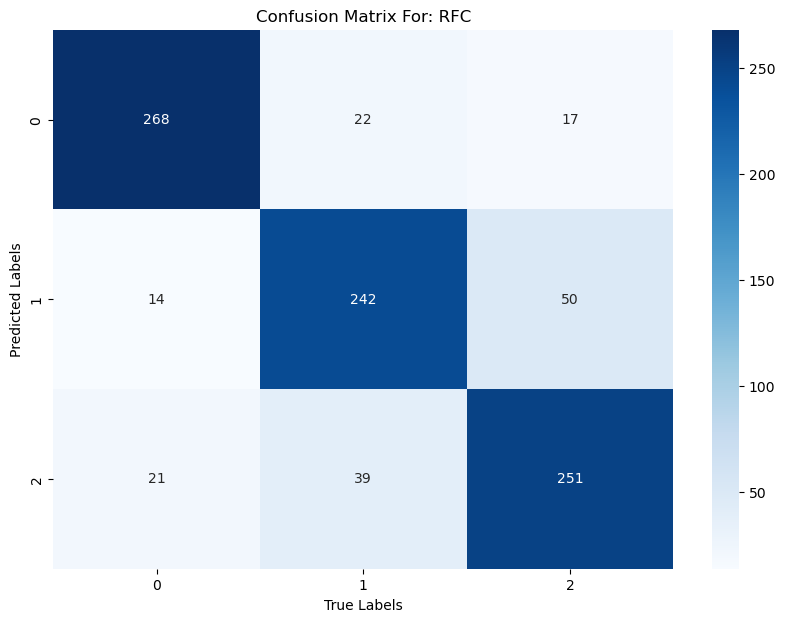

The Best Param: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
2,RFC,0.823593,0.823842,0.823629,0.824159
0,XGB,0.817100,0.817474,0.817118,0.818127
1,GBC,0.813853,0.814331,0.813958,0.814786


In [54]:
model_names = ["XGB", "GBC", "RFC"]
models = grab_selected_models(model_names)
performance_df, tree_models = optimization_search( model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
performance_df

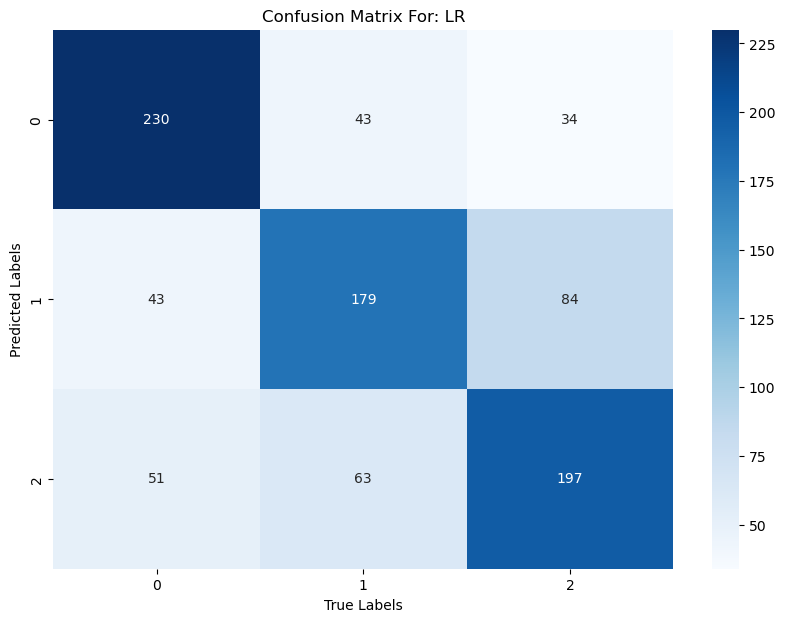

The Best Param: {'model__solver': 'saga', 'model__penalty': 'l1', 'model__C': 1}


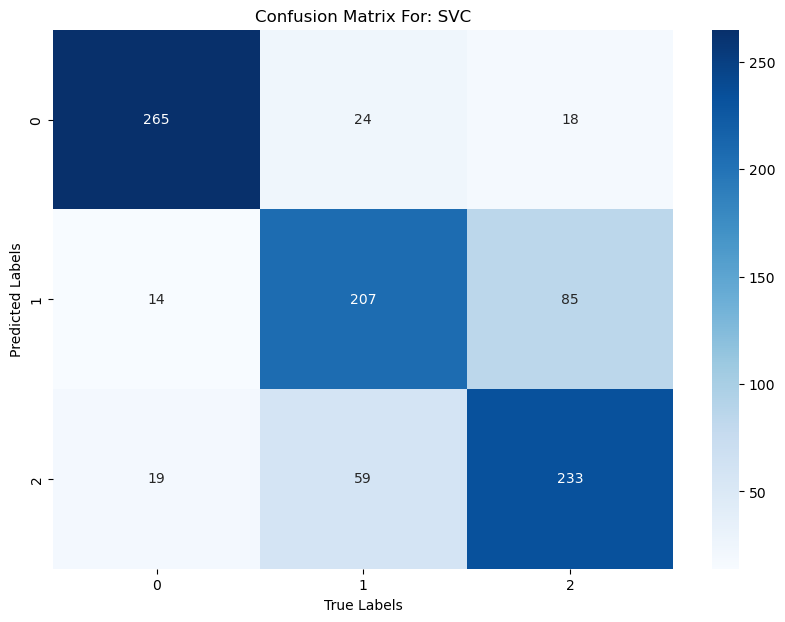

The Best Param: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__degree': 2, 'model__C': 10}


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


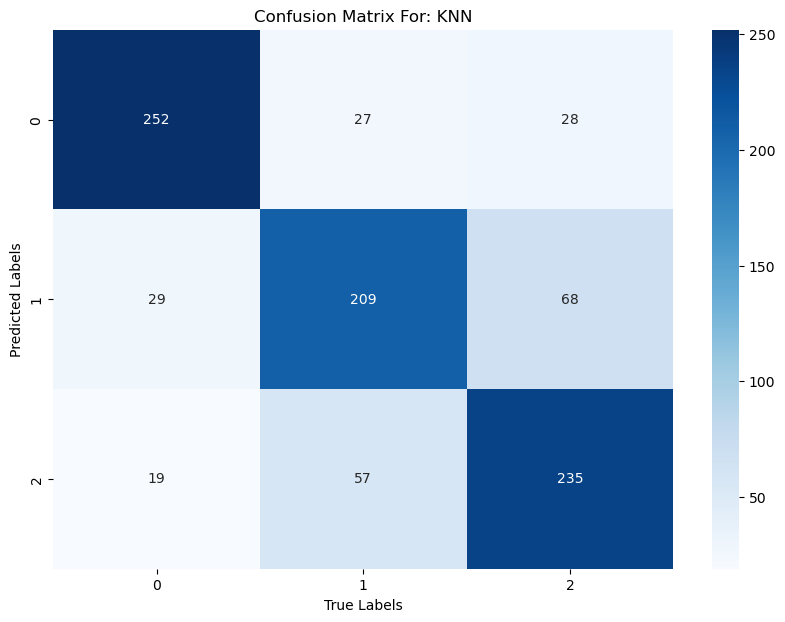

The Best Param: {}


,Model,Test-Acc,F1-Score,recall-Score,precision-Score
1,SVC,0.762987,0.763637,0.762953,0.765502
2,KNN,0.753247,0.753410,0.753160,0.754427
0,LR,0.655844,0.654716,0.655865,0.654448


In [55]:
model_names = ["LR", "SVC", "KNN"]
models = grab_selected_models(model_names)
performance_df, conventional_models = optimization_search( model_names, models, X, y_encoded, RandomizedSearchCV, params, acc_metric, kbest)
performance_df

In [ ]:
voting_clf = VotingClassifier(
  [
  ("XGB", tree_models[0]),
  ("GBC",tree_models[1]),
  ("RFC",tree_models[2])
  ],
  voting="soft"
)

models = [voting_clf]
